# Reconstructed Fossil Data

### Overview
This notebook covers
- assigning plate ids to a collection of point data
- extracting finite rotations for a given plate from a rotation model
- applying finite rotations to a feature to get a reconstructed feature



In [63]:
import requests
from io import StringIO
import matplotlib.pyplot as plt
import pandas as pd
import pygplates
import numpy as np
from mpl_toolkits.basemap import Basemap

%matplotlib inline

### Load More Fossil Data

In common with previous exercises, this notebook uses data from the pbdb. The http request below is similar to what we used before, but has some important differences. Look at the next cell and identify the different request parameters, and what they will mean for the data we download.


In [64]:
time_min = 0.
time_max = 200.

r = requests.get('https://paleobiodb.org/data1.2/occs/list.csv?base_name=Bryozoa&max_ma=%d&min_ma=%d&show=coords' \
                 % (time_max,time_min))
#print r.text

df = pd.read_csv(StringIO(r.text))

df.columns

Index([u'occurrence_no', u'record_type', u'reid_no', u'flags',
       u'collection_no', u'identified_name', u'identified_rank',
       u'identified_no', u'difference', u'accepted_name', u'accepted_rank',
       u'accepted_no', u'early_interval', u'late_interval', u'max_ma',
       u'min_ma', u'reference_no', u'lng', u'lat'],
      dtype='object')

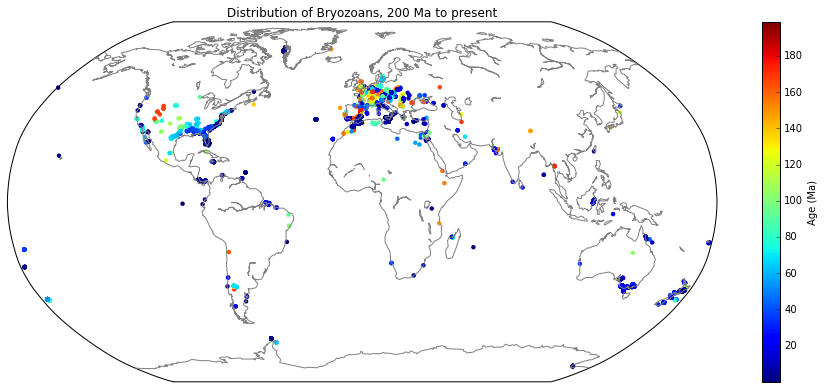

In [61]:
fig = plt.figure(figsize=(14,5))
ax_map = fig.add_axes([0,0,0.9,1.0])
m = Basemap(projection='robin', lon_0=0, resolution='c', ax=ax_map)
m.drawcoastlines(color='gray')
x,y = m(np.array(df.lng),np.array(df.lat))
plt.scatter(x,y,c=(df.max_ma+df.min_ma)/2.,edgecolors='')
plt.colorbar(label='Age (Ma)')
plt.title('Distribution of Bryozoans, 200 Ma to present')
plt.show()


### Exercise - paleolatitudinal zoning of Bryozoans

The exercise from here is to carry out an analysis similar to that shown in the 1998 Geology paper by Taylor and Allison, entitled 'Bryozoan carbonates through time and space'. 

http://geology.geoscienceworld.org/content/26/5/459

We should be able to recreate the figures from that paper using data from pbdb and some python code.

The broad steps are outlined below - the example code within the tutorials 'pygplates-assign-plateids' and 'pygplates-reconstruct-to-birth-time' should be useful guides.

1. Use the Seton et al (2012) reconstruction model to assign plate ids to each fossil (ie find which plate polygon it lies within, according to that reconstruction model).
2. For each fossil, get a rough age for this fossil and determine the finite pole of rotation that will reconstruct each fossil to the absolute location at time of deposition.
3. Use matplotlib to make plots of the paleo-fossil locations, specifically paleolatitude-vs-time and a histogram of fossil paleolatitudes. 


In [62]:
# SOLUTION 
# Part 1: Creating a feature collection with plate id assignments

# static polygons are the 'partitioning features'
static_polygons = pygplates.FeatureCollection('Data/Seton_etal_ESR2012_StaticPolygons_2012.1.gpmlz')

# The partition_into_plates function requires a rotation model, since sometimes this would be
# necessary even at present day (for example to resolve topological polygons)
rotation_model=pygplates.RotationModel('Data/Seton_etal_ESR2012_2012.1.rot')

# put the points into a feature collection, using Lat,Long coordinates from dataframe
point_features = []
for index,row in df.iterrows():
    point = pygplates.PointOnSphere(float(row.lat),float(row.lng))
    point_feature = pygplates.Feature()
    point_feature.set_geometry(point)
    point_feature.set_valid_time(row.max_ma,row.min_ma)
    point_features.append(point_feature)
    
# The partition points function can then be used as before
partitioned_point_features = pygplates.partition_into_plates(static_polygons,
                                                       rotation_model,
                                                       point_features)


In [33]:
# SOLUTION 
# Part 2: Reconstruct the feature collection 
Xr = []
Yr = []
Age = []

for feature in partitioned_point_features:
    
    # NB valid_time is a tuple, we take the first value since this is the 'birth' time of the LIP
    BirthTime = feature.get_valid_time()[0]   
    PlateID = feature.get_reconstruction_plate_id()

    # Get rotation for data point and reconstruct to 0Ma
    Fossil_rotation = rotation_model.get_rotation(BirthTime, PlateID, anchor_plate_id=0)
    
    reconstructed_point = Fossil_rotation * feature.get_geometry()
    reconstructed_point_degrees = reconstructed_point.to_lat_lon_point()

    Xr.append(reconstructed_point_degrees.get_longitude())
    Yr.append(reconstructed_point_degrees.get_latitude())
    Age.append(BirthTime)
        

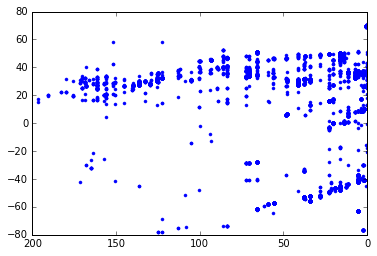

In [43]:
# SOLUTION
# Part 3: Paleolatitude versus Age for reconstructed fossils
plt.plot(Age,Yr,'.')
plt.xlim(200,0)
plt.xlabel('Age (Ma)')
plt.ylable('Paleolatitude')
plt.show()


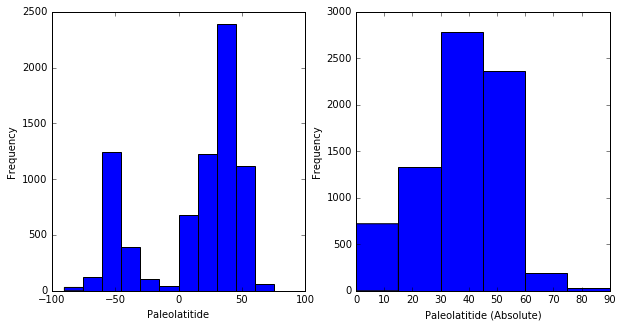

In [59]:
# SOLUTION 
# Part 4: Histograms of paleolatitude for the 0-200 Ma interval
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.hist(Yr,bins=np.arange(-90,91,15))
plt.xlabel('Paleolatitide')
plt.ylabel('Frequency')

plt.subplot(122)
plt.hist(np.abs(Yr),bins=np.arange(0,91,15))
plt.xlabel('Paleolatitide (Absolute)')
plt.ylabel('Frequency')
plt.show()


Having completed steps 1-3, consider the following questions:
- Do your plots look similar to the results in the Taylor and Allison (1998) paper? Make a list of all the factors that could explain differences between their results and your own.
- the instructions told you to use the Seton et al (2012) rotation model. Should you have listened to the instructions? Consider using a different reconstruction model, how this might change your analysis (both in terms of extending the results further back in time, and how it would change the results for 0-200 Ma)
- Think about some of the limitations of the analysis. Think about whether the paleolatitudinal distribution of fossils is influenced by biases in the fossil record, how and why this would happen and what steps you could take to explore this issue.
